In [1]:
import re
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed(123)

In [2]:
device = 'cuda'

In [30]:
def process(input_string):
    return re.sub(r"[^а-яёА-ЯЁ\s]", "", input_string).lower().strip().replace("\xa0", " ").replace("\u200a", "").replace("\n", " ")

In [31]:
input_data: str
with open("russian_text.txt", "r", encoding='utf-8') as f:
    input_data = process(" ".join(f.readlines()))

In [32]:
input_data

'рекуррентные нейронные сети и шифр цезаря    рекуррентные нейронные сети     представляют собой класс нейронных сетей специально разработанных для работы с последовательными данными они эффективно используются для обработки временных рядов текстов сигналов и других последовательностей где текущие значения зависят от предыдущих одним из возможных приложений  является решение криптографических задач таких как взлом и анализ простых шифров например шифра цезаря         шифр цезаря    шифр цезаря  один из самых древних и простых методов шифрования этот метод основывается на сдвиге каждой буквы в сообщении на фиксированное число позиций в алфавите например если ключ шифра равен  то буква а становится г б  д и так далее в конце алфавита сдвиг продолжается циклически то есть после я идёт а    пример шифрования   оригинальный текст пример   ключ    зашифрованный текст тулпер    шифр цезаря считается устаревшим так как он легко поддаётся взлому методами частотного анализа однако его простота д

In [33]:
class Cypherer:
    def __init__(self, step: int = 1) -> None:
        if step < 1:
            raise ValueError

        self.alph = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя"
        self.cypher_d = {self.alph[i]: self.alph[(i+step)%len(self.alph)] for i in range(len(self.alph))}
        self.cypher_d[" "] = " "
        self.decypher_d = {v: k for k,v in self.cypher_d.items()}

    def cypher_symb(self, s: str) -> str:
        return self.cypher_d[s]

    def decypher_symb(self, s: str) -> str:
        return self.decypher_d[s]

    def cypher(self, s: str) -> str:
        return "".join([self.cypher_symb(c) for c in s])

    def decypher(self, s: str) -> str:
        return "".join([self.decypher_symb(c) for c in s])

    def stoi_symb(self, s: str) -> int:
        if s == " ":
            return 33  # Условный индекс для пробела
        return {v: idx for idx, v in enumerate(self.alph)}[s]

    def itos_symb(self, idx: int) -> str:
        if idx == 33:
            return " "  # Возврат пробела для условного индекса
        return {idx: v for idx, v in enumerate(self.alph)}[idx]

    def stoi(self, s: str) -> list[int]:
        return [self.stoi_symb(c) for c in s]

    def itos(self, idxs: list[int]) -> str:
        return "".join([self.itos_symb(x) for x in idxs])

In [34]:
cypherer = Cypherer(12)

In [35]:
test = input_data[:50]
test

'рекуррентные нейронные сети и шифр цезаря    рекур'

In [36]:
test_cyphered = cypherer.cypher(test)
test_cyphered

'ьрцяььрщющжр щрхьъщщжр эрюф ф дфаь врульк    ьрцяь'

In [37]:
cypherer.decypher(test_cyphered)

'рекуррентные нейронные сети и шифр цезаря    рекур'

In [38]:
test_stoi = cypherer.stoi(test_cyphered)
print(test_stoi)
test_itos = cypherer.itos(test_stoi)
print(test_itos)

[29, 17, 23, 32, 29, 29, 17, 26, 31, 26, 7, 17, 33, 26, 17, 22, 29, 27, 26, 26, 7, 17, 33, 30, 17, 31, 21, 33, 21, 33, 4, 21, 0, 29, 33, 2, 17, 20, 12, 29, 11, 33, 33, 33, 33, 29, 17, 23, 32, 29]
ьрцяььрщющжр щрхьъщщжр эрюф ф дфаь врульк    ьрцяь


In [39]:
chunk_size = 128

In [40]:
data_str = [input_data[i:i+chunk_size] + "".join(([" "] * (chunk_size - len(input_data[i:i+chunk_size])))) for i in range(0, len(input_data), chunk_size)]
assert len("".join(data_str)) % chunk_size == 0
data_str[0], data_str[1]

('рекуррентные нейронные сети и шифр цезаря    рекуррентные нейронные сети     представляют собой класс нейронных сетей специально',
 ' разработанных для работы с последовательными данными они эффективно используются для обработки временных рядов текстов сигналов')

In [41]:
def create_chunks(input_data: str) -> torch.Tensor:
    # Дополнение строки пробелами до кратности chunk_size
    t = input_data + "".join([" "] * (chunk_size - (len(input_data) % chunk_size)))
    c = cypherer.stoi(t)
    assert len(c) % chunk_size == 0

    # Отслеживание прогресса
    num_chunks = len(c) // chunk_size  # Общее количество чанков
    chunks = []
    for i in tqdm(range(0, len(c), chunk_size), desc="Creating chunks", unit="chunk"):
        chunks.append(c[i:i + chunk_size])

    return torch.tensor(chunks).to(device)

In [42]:
data = create_chunks(input_data)

Creating chunks: 100%|██████████| 819/819 [00:00<00:00, 819645.66chunk/s]


In [43]:
data.shape

torch.Size([819, 128])

In [44]:
cyphered_data = create_chunks(cypherer.cypher(input_data))
cyphered_data.shape

Creating chunks: 100%|██████████| 819/819 [00:00<00:00, 409676.20chunk/s]


torch.Size([819, 128])

In [45]:
cypherer.itos(cyphered_data[0].tolist()), cypherer.itos(data[0].tolist())

('ьрцяььрщющжр щрхьъщщжр эрюф ф дфаь врульк    ьрцяььрщющжр щрхьъщщжр эрюф     ыьрпэюлнчкйю эъмъх цчлээ щрхьъщщжб эрюрх эырвфлчзщъ',
 'рекуррентные нейронные сети и шифр цезаря    рекуррентные нейронные сети     представляют собой класс нейронных сетей специально')

In [46]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(cyphered_data, data, test_size=0.2)

In [47]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

In [48]:
batch_size = 64

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size, True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size, False, drop_last=True)

In [50]:
class CaesarCypher(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size, num_layers)
        self.decoder = nn.GRU(hidden_size, hidden_size, num_layers)

        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.embedding(x).squeeze(2)

        tmp = torch.zeros((1, chunk_size, self.hidden_size)).to(device)
        x, hidden = self.encoder(x, tmp)
        hidden = hidden.to(device)

        x, hidden = self.decoder(x, hidden)
        x = self.fc(x)
        return self.activation(x)

In [51]:
lr = 1e-3
epochs = 10
hidden_size = 512
output_size = len(cypherer.alph) + 1

In [52]:
model = CaesarCypher(hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [53]:
train_loss = []
val_loss = []

def train(model: nn.Module, epochs: int, train_data: DataLoader, val_data: DataLoader, criterion: nn.modules.loss._Loss, optimizer: optim.Optimizer):
    for epoch in range(epochs):
        model.train()
        mean_loss = 0
        n_batches = 0
        for x_batch, y_batch in train_data:
            print(f"Batch {n_batches}/{len(train_data)}", end="\r")
            optimizer.zero_grad()
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.reshape(batch_size, -1, 1)
            pred: torch.Tensor = model(x_batch)
            pred = pred.to(device)
            loss = criterion(pred, F.one_hot(y_batch, output_size).float())
            loss.backward()
            optimizer.step()

            mean_loss += loss.item()
            n_batches += 1

        train_loss.append(mean_loss / len(train_data))

        model.eval()
        mean_loss = 0
        n_batches = 0
        with torch.no_grad():
            for x_batch, y_batch in val_data:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                x_batch = x_batch.reshape(batch_size, -1, 1)
                pred: torch.Tensor = model(x_batch)
                pred = pred.to(device)
                loss = criterion(pred, F.one_hot(y_batch, output_size).float())

                mean_loss += loss.item()
                n_batches += 1


            rand_idx = random.randint(0, batch_size-1)
            rand_str = cypherer.itos(y_batch[rand_idx].cpu().numpy())
            pred_str = cypherer.itos(torch.argmax(pred[rand_idx], 1).cpu().numpy())
            print(f"Rand str: {rand_str}\nPred str: {pred_str}")

        val_loss.append(mean_loss / len(val_data))
        print(f"Epoch {epoch+1}/{epochs} train loss: {train_loss[-1]:.4f} val loss: {val_loss[-1]:.4f}")

In [54]:
train(model, epochs, train_dataloader, val_dataloader, criterion, optimizer)

Rand str: лфэобуыхтнвкввнччюедбначпыфдяакенфйитттуёющэыоукмэжяързскпхгтефркаёнияаеклщаптъэшдъчкишздфчксежвббьмюэрифъъйзбдоынйсёдсчгпаяфиык
Pred str: лфэобуыхтнвкввнччюедбначпыфдяакенфйитттуёющэыоукмэжяързскпхгтефркаёнияаеклщаптъэшдъчкишздфчксежвббьмюэрифъъйзбдоынйсёдсчгпаяфиык
Epoch 1/10 train loss: 13.3966 val loss: 6.5210
Rand str: гикбойдъзмжжрюктйазнцьвуйшгбоншёдйсёщ гв лэцопытчлдоцжщчэпяыпдф ожикбюыладшмхэщжзцпыихючёрмтйщхтча ъжнказ  нвяикбцщокдошхудкмйхщ
Pred str: гикбойдъзмжжрюктйазнцьвуйшгбоншёдйсёщ гв лэцопытчлдоцжщчэпяыпдф ожикбюыладшмхэщжзцпыихючёрмтйщхтча ъжнказ  нвяикбцщокдошхудкмйхщ
Epoch 2/10 train loss: 5.7904 val loss: 5.6385
Rand str: ьбсвчкодфькипцсхрнгнуьакёъсбэуаюрхищфпюрёалтньфжиовеу стмжынртмнююкыягшонвжывофчюртхжхщлфписотпеьщббщшыбшжшгхвнкш шуьшедмгиажосв
Pred str: ьбсвчкодфькипцсхрнгнуьакёъсбэуаюрхищфпюрёалтньфжиовеу стмжынртмнююкыягшонвжывофчюртхжхщлфписотпеьщббщшыбшжшгхвнкш шуьшедмгиажосв
Epoch 3/10 train loss: 5.5975 val loss: 5.6272
Rand str: зщртвяойеыятул

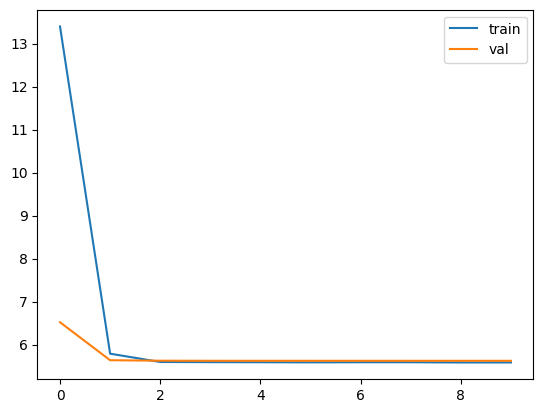

In [55]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()

In [56]:
model.eval()

rand_idx = random.randint(0, len(val_x))
pred = model(val_x[rand_idx].reshape(1, -1, 1).to(device)).argmax(2).squeeze(0).cpu().numpy()
print(cypherer.itos(pred)) # pred
print(cypherer.itos(val_y[rand_idx].cpu().numpy())) # true

мужоаиаы вдяуетмпдчгтэхзкупщеужзтутащояздиуфч гщбзрэьлхэымм нвыщоьлгъуфъосфдпрщтл эйвддгооьнчврыфщызщкхащпснкокибдгдыпащгхтслрпд
мужоаиаы вдяуетмпдчгтэхзкупщеужзтутащояздиуфч гщбзрэьлхэымм нвыщоьлгъуфъосфдпрщтл эйвддгооьнчврыфщызщкхащпснкокибдгдыпащгхтслрпд
